# Generating Synthetic Data with SMOTE

David Pugh, July 2018

Investigating the use of SMOTE and ADASYN to generate synthetic data based on a false dataset.

In [37]:
from imblearn.over_sampling import ADASYN, SMOTE
from imblearn.pipeline import make_pipeline
from sklearn import datasets
from sklearn import model_selection
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import math
from scipy import stats

print(__doc__)
%matplotlib inline

Automatically created module for IPython interactive environment


In [38]:
RANDOM_STATE = 32

### Create Dataset

In [39]:
n_features = 4

X,y = datasets.make_classification(n_classes=2, class_sep=2,
                                  weights=[0.0, 1.0], n_informative=3,
                                  n_redundant=1, flip_y=0, n_features=n_features,
                                  n_clusters_per_class=2, n_samples=100000,
                                  random_state=RANDOM_STATE)




Now create a dataset with 2:1 ratio


In [40]:
original_df = pd.DataFrame(X)
original_df['target'] = 0
print(original_df.head())
print(original_df.groupby('target').count())

cols=list(range(0,n_features))
#create a df with 2x orginal data with target =0
original_2_df = original_df.append(original_df)

#Add teh original again but with target = 1
original_df['target'] = 1
original_2_df = original_2_df.append(original_df)
print(original_2_df.info())

print(original_2_df.groupby('target').count())

# you want all rows, and the feature_cols' columns
X = original_2_df.iloc[:, :-1].values
y = original_2_df['target'].values

          0         1         2         3  target
0 -2.520006 -1.994877  2.249217  1.411174       0
1 -0.468366  1.844727 -2.143157 -0.342865       0
2  3.004334 -1.339810  1.151008 -1.288654       0
3 -2.404513 -2.182824  2.195799  1.057915       0
4 -2.679495 -3.449538  4.571877  2.723981       0
             0       1       2       3
target                                
0       100000  100000  100000  100000
<class 'pandas.core.frame.DataFrame'>
Int64Index: 300000 entries, 0 to 99999
Data columns (total 5 columns):
0         300000 non-null float64
1         300000 non-null float64
2         300000 non-null float64
3         300000 non-null float64
target    300000 non-null int64
dtypes: float64(4), int64(1)
memory usage: 13.7 MB
None
             0       1       2       3
target                                
0       200000  200000  200000  200000
1       100000  100000  100000  100000


### Create Samplers

In [41]:
samplers = [
    ['ADASYN', ADASYN(random_state=RANDOM_STATE)],
    ['SMOTE - Reg', SMOTE(kind='regular', random_state=RANDOM_STATE)],
    ['SMOTE - B1', SMOTE(kind='borderline1', random_state=RANDOM_STATE)],
    ['SMOTE - B2', SMOTE(kind='borderline2', random_state=RANDOM_STATE)],
    #['SMOTE - SVM', SMOTE(kind='svm', random_state=RANDOM_STATE)]
]

###  Define function to plot correlation matrix

In [42]:
def correlation_matrix(df, title, file=""):
    plt.figure(figsize=(10,10))
    corr_plot = sns.heatmap(df, annot=True, square=True, cmap='coolwarm', vmax=1, vmin=-1).set_title(title)
    
    if file != "":
        fig = corr_plot.get_figure()
        fig.savefig(file+'.png', bbox_inches='tight')

In [43]:
def bhatta ( hist1,  hist2):
  '''Calculates the Byattacharyya distance of two histograms.'''

  def normalize(h):
    return h / np.sum(h)

  return 1 - np.sum(np.sqrt(np.multiply(normalize(hist1), normalize(hist2))))

In [44]:
def return_intersection(hist1, hist2):
    minima = np.minimum(hist1, hist2)
    intersection = np.true_divide(np.sum(minima), np.sum(hist2))
    return intersection

### Define function to resample data and compare with original

In [45]:
def resample_and_compare(X,y,sampler, folder):
    #Create a resampled data set 
    X_res, y_res = sampler[1].fit_sample(X,y)
    resampled_df = pd.DataFrame(X_res)
    resampled_df['target'] = y_res
    
    #Merge resampled and original data, then drop duplicates
    merged_df = pd.concat([original_df, resampled_df])
    #these are the new resampled datapoints
    generated_df = merged_df.drop_duplicates(keep=False).reset_index(drop=True)
    #print(generated_df.info())
    
    generated_df['sampler'] = sampler[0]
    #correlate each original dataset minoroty classes with the new resampled one
    print("\n------------------------------------------------------------------------\n")
    print("----------- " + sampler[0])
    
    #plt.figure()
    figfile = folder + '/orig_and_gen_data_'+ sampler[0]
    f, axes = plt.subplots(n_features, figsize=(8,10))
    """f.subplots_adjust(left=0.125, 
                        bottom=0.1, 
                        right=0.9, 
                        top=2.0,
                        wspace=0.2, 
                        hspace=0.2)"""
    
    axes[0].set_title("Original and Generated Data using " + sampler[0], fontsize="x-large")
    
    pearsonrs=[]
    intersections=[]
    bhatts=[]
    method =[]
    for i in cols:
        s = sns.distplot(generated_df[i], hist=False, rug=False, label="G-"+ str(i), ax=axes[i], 
                     kde_kws={'linestyle':'-', 'linewidth':3})
        sns.distplot(original_df[i], hist=False, rug=False, label="O-"+ str(i), ax=axes[i], 
                     kde_kws={'linestyle':'--', 'linewidth':2})
        
        
        o_hist, _ = np.histogram(original_df[i], bins=100)
        g_hist, _ = np.histogram(generated_df[i], bins=100)
        bhatt = bhatta(o_hist, g_hist)  
        intersection = return_intersection(o_hist, g_hist)
        pearson = stats.pearsonr(o_hist,g_hist)
        
        pearsonrs.append(pearson[0])
        bhatts.append(bhatt)
        intersections.append(intersection)
        method.append(sampler[0])
        
        print("Intersection for {}: {:03.2f} ".format(i ,intersection ))
        #axes[i].text(0.15, 0.85,'Intersection:{} '.format(intersection), fontsize=9) #add text
        s.text(0.02, 0.90,'Pearson Coeff:', 
                     fontsize=8,  horizontalalignment='left',
                     verticalalignment='center',
                     transform = axes[i].transAxes)
        s.text(0.2, 0.90,'{:05.3f}'.format(pearson[0]), 
                     fontsize=8,  horizontalalignment='left',
                     verticalalignment='center',
                     transform = axes[i].transAxes)
        
        s.text(0.02, 0.80,'Intersection:', 
                     fontsize=8,  horizontalalignment='left',
                     verticalalignment='center',
                     transform = axes[i].transAxes)
        s.text(0.2, 0.80,'{:05.3f}'.format(intersection), 
                     fontsize=8,  horizontalalignment='left',
                     verticalalignment='center',
                     transform = axes[i].transAxes)       
        
        s.text(0.02, 0.70,'Bhattacharyya Dist:', fontsize=8,  horizontalalignment='left',
                     verticalalignment='center',
                     transform = axes[i].transAxes)
        s.text(0.2, 0.70,'{:05.3f}'.format(bhatt), 
                     fontsize=8,  horizontalalignment='left',
                     verticalalignment='center',
                     transform = axes[i].transAxes)
        
    f.savefig(figfile+'.png', bbox_inches='tight')

    #print("Original Data")
    #print(original_df.head())
    original_corr = original_df.iloc[:, :-1].corr()
    
    #print("Generated Data")
    #print(generated_df.head())    
    gen_corr = generated_df.iloc[:, :-2].corr()
    
    print("\nCorrelation Matrix - {}".format(sampler[0]))
    correlation_matrix(gen_corr, 'Generated Data '+ sampler[0])
    
    print("Correlation Matrix Diff - {}".format(sampler[0]))
    correlation_matrix(original_corr - gen_corr, 'Correlation Difference ' + sampler[0], folder + '/corr_diff_data_'+ sampler[0])
    
    summary_df = pd.DataFrame( data = {'method': method,
                                       'feature': cols, 
                                       'pearsonr': pearsonrs, 
                                       'intersection': intersections,
                                       'bhattacharyya': bhatts})

    summary_df.to_csv(folder + '/summary_stats_'+ sampler[0], index=False)

### Correlation plot of the original data

     0    1    2    3
0  0.0  0.0  0.0  0.0
1  0.0  0.0  0.0  0.0
2  0.0  0.0  0.0  0.0
3  0.0  0.0  0.0  0.0


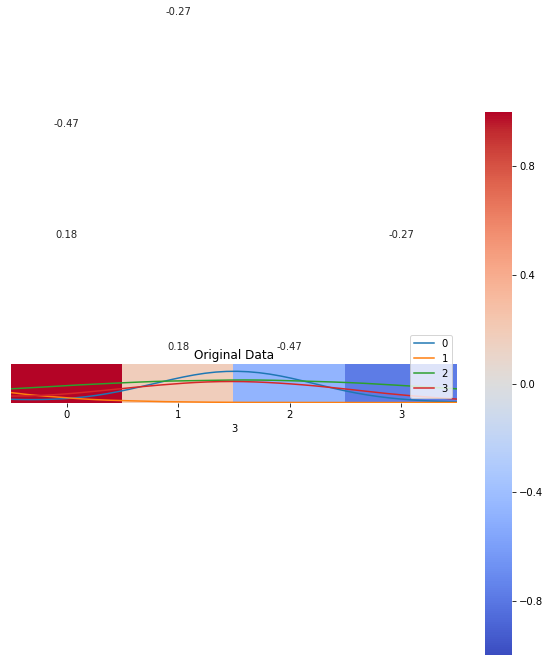

In [46]:
orignal_corr  = original_df.iloc[:, :-1].corr()
print(orignal_corr - orignal_corr )
correlation_matrix(orignal_corr, 'Original Data')

for i in cols:
    sns.distplot(original_df[i], hist=False, rug=False, label=i)
    plt.legend()


In [47]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

### Generate synthetic data for each sampler type and compare correlation matrix to original data


------------------------------------------------------------------------

----------- ADASYN
Intersection for 0: 0.94 
Intersection for 1: 0.89 
Intersection for 2: 0.88 
Intersection for 3: 0.98 

Correlation Matrix - ADASYN
Correlation Matrix Diff - ADASYN

------------------------------------------------------------------------

----------- SMOTE - Reg
Intersection for 0: 0.96 
Intersection for 1: 0.89 
Intersection for 2: 0.93 
Intersection for 3: 0.97 

Correlation Matrix - SMOTE - Reg
Correlation Matrix Diff - SMOTE - Reg

------------------------------------------------------------------------

----------- SMOTE - B1
Intersection for 0: 0.96 
Intersection for 1: 0.89 
Intersection for 2: 0.93 
Intersection for 3: 0.97 

Correlation Matrix - SMOTE - B1
Correlation Matrix Diff - SMOTE - B1

------------------------------------------------------------------------

----------- SMOTE - B2
Intersection for 0: 0.96 
Intersection for 1: 0.91 
Intersection for 2: 0.95 
Intersection for 

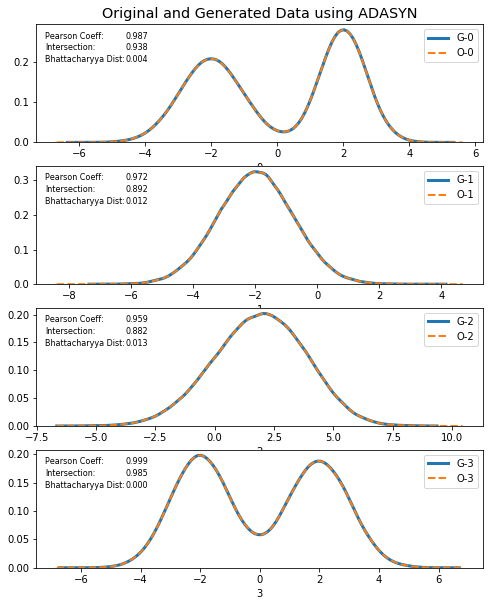

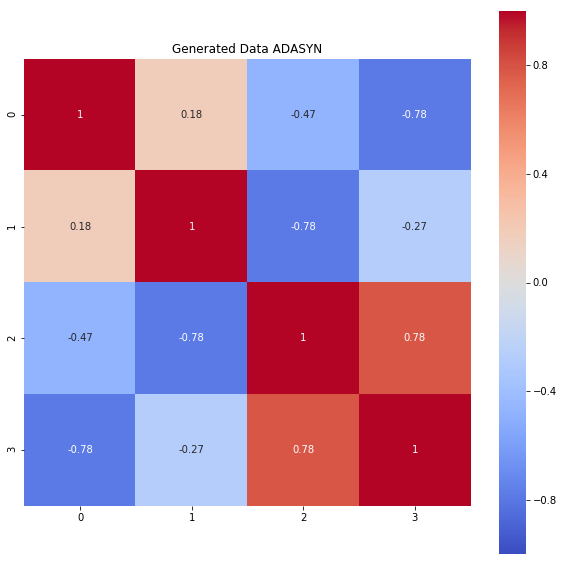

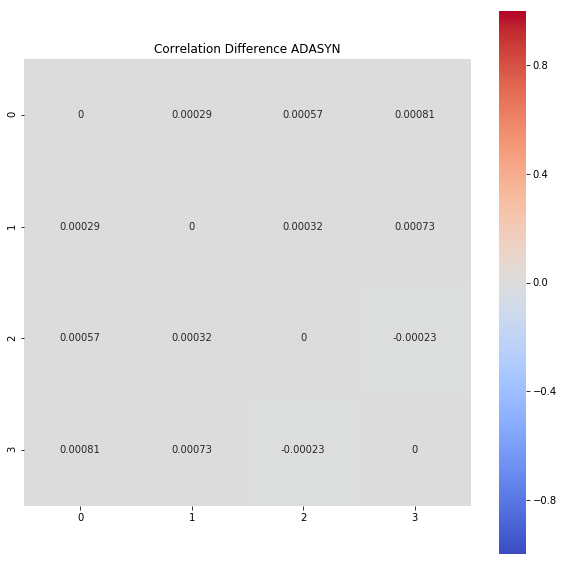

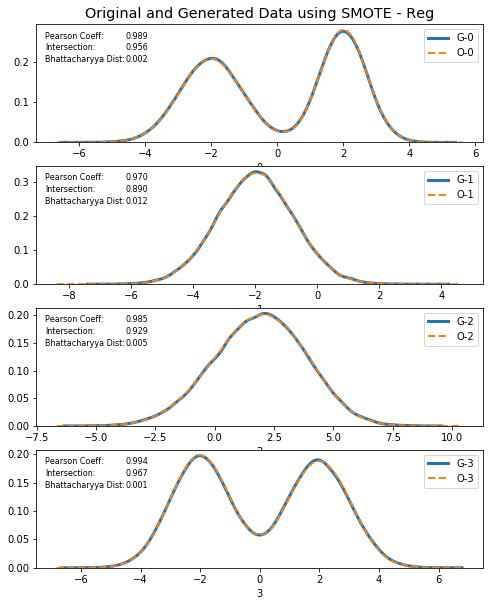

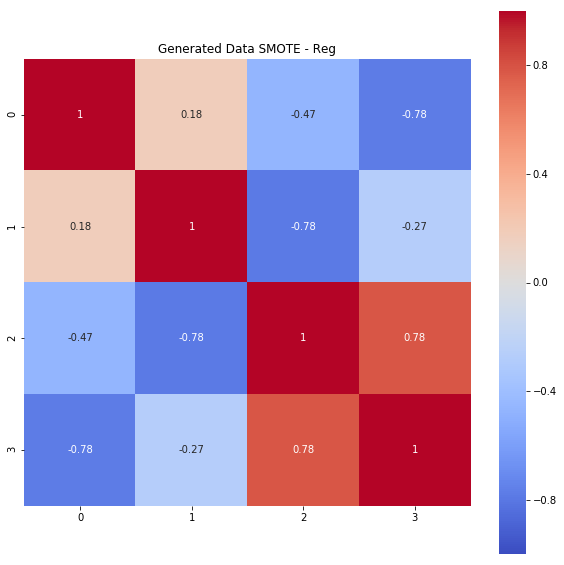

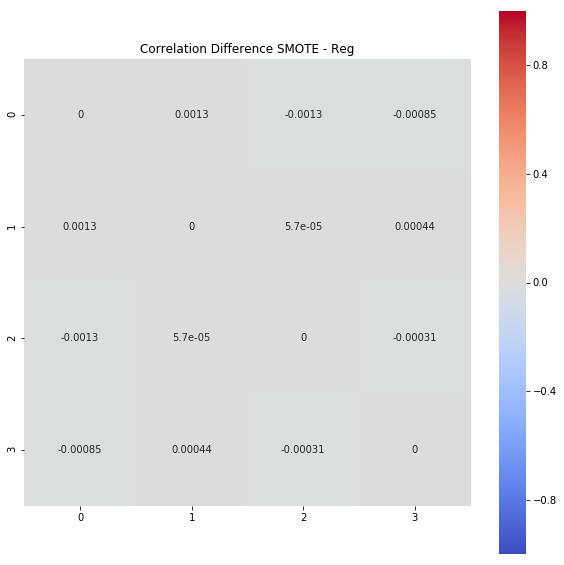

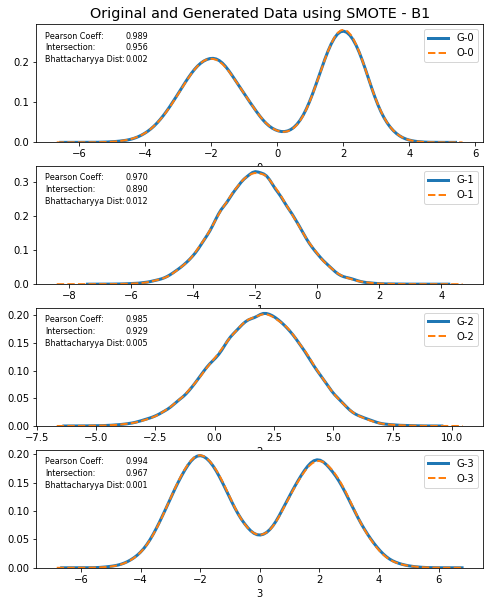

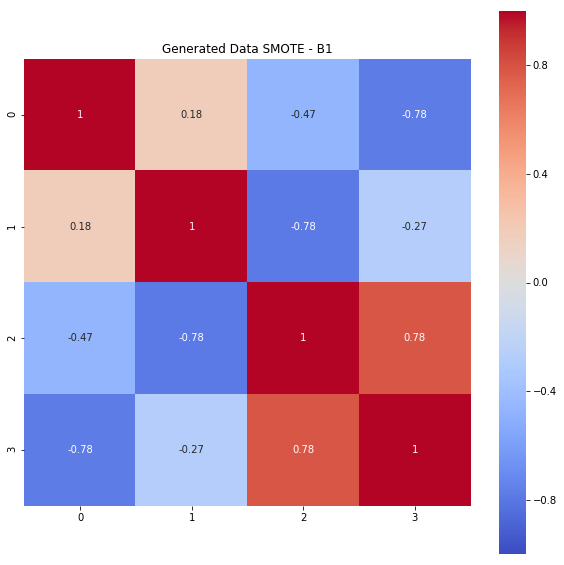

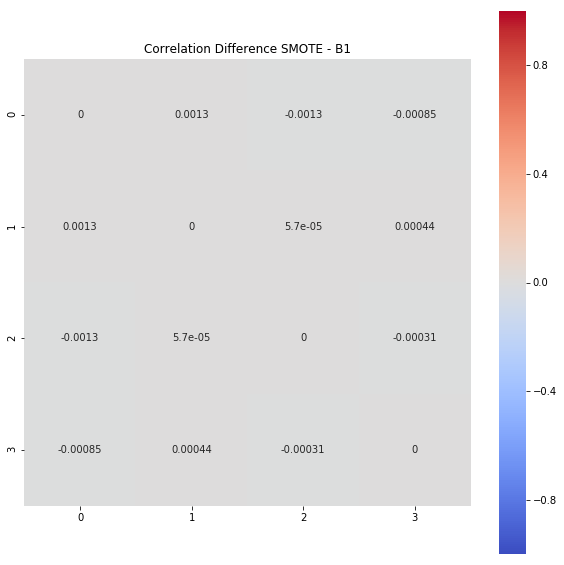

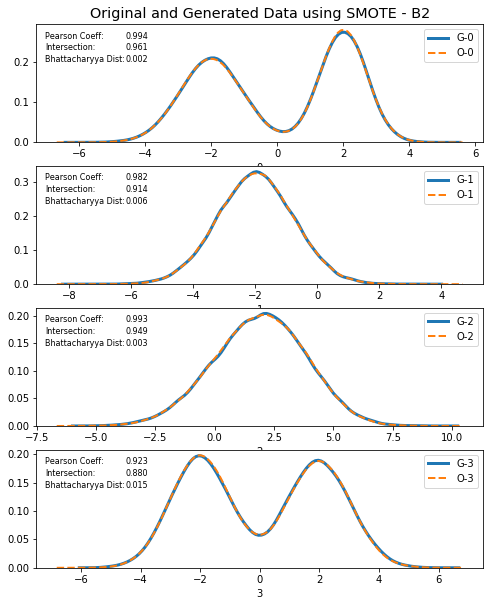

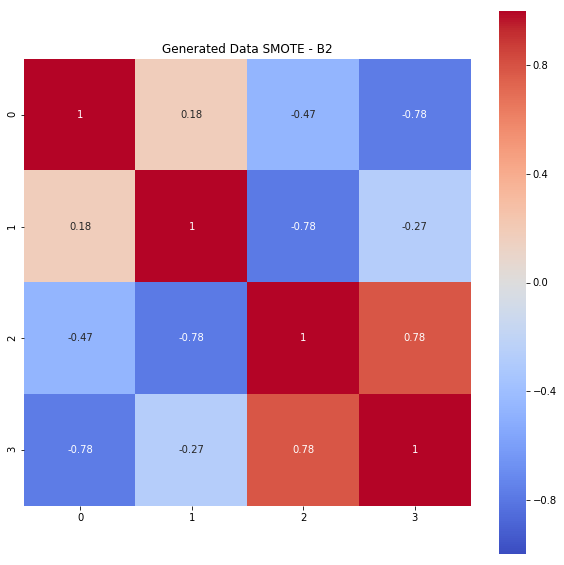

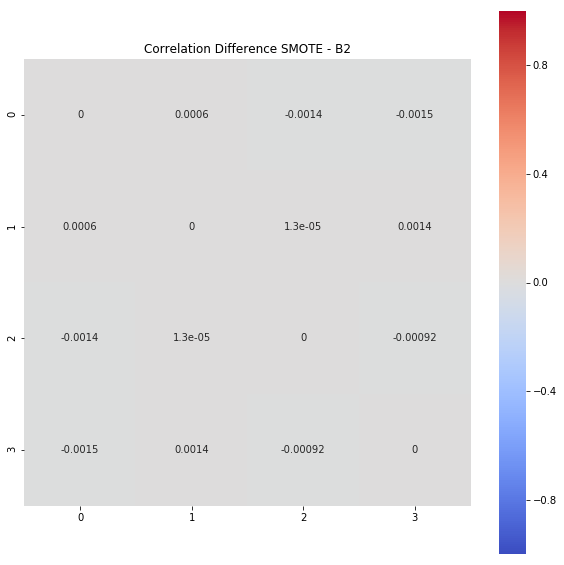

In [48]:
for sampler in samplers:
    resample_and_compare(X,y,sampler,'smote_generated_data')

### 